In [1]:
# Upgrade pip and install required packages
!pip install --upgrade pip --no-cache-dir
!pip install gensim==4.3.3 --no-cache-dir
!pip install pyLDAvis==3.4.1 --no-cache-dir
!pip install wordcloud==1.9.4 --no-cache-dir
!pip install plotly==6.3.0 --no-cache-dir
!pip install openpyxl==3.1.5 --no-cache-dir

# Install NLTK and download required data
import nltk
print("📥 Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Verify installations
try:
    import gensim
    import pyLDAvis
    import wordcloud
    import plotly
    import openpyxl
    print("✅ All packages installed successfully!")
    print(f"🔍 Gensim version: {gensim.__version__}")  # Should print: 4.3.3
    print(f"🔍 pyLDAvis version: {pyLDAvis.__version__}")  # Should print: 3.4.1
    print(f"🔍 Ready for LDA topic modeling analysis")
except ImportError as e:
    print(f"❌ Installation failed: {e}")
    raise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 202.7 MB/s  0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
📥 Downloading NLTK data...
✅ All packages installed successfully!
🔍 Gensim version: 4.3.3
🔍 pyLDAvis version: 3.4.0
🔍 Ready for LDA topic modeling analysis


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
from IPython.display import display, HTML
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from scipy.sparse import lil_matrix

plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
print("✅ All libraries imported successfully!")
print("📊 Google Colab environment ready for analysis")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✅ All libraries imported successfully!
📊 Google Colab environment ready for analysis


In [3]:
# Configuration and Constants
GRIEVANCE_KEYWORDS = [
    'grievance mechanism', 'complaint mechanism', 'reporting mechanism', 'redress mechanism',
    'feedback mechanism', 'disclosure mechanism', 'concern reporting', 'issue reporting',
    'grievance procedure', 'complaint procedure', 'whistleblowing', 'whistleblower',
    'hotline', 'helpline', 'anonymous reporting', 'confidential reporting', 'speak up',
    'report line', 'ethics line', 'integrity line', 'supplier grievance', 'worker voice',
    'supply chain reporting', 'worker feedback', 'employee reporting', 'stakeholder grievance',
    'supplier code of conduct', 'worker helpline', 'supply chain hotline', 'worker empowerment',
    'independent grievance', 'third-party reporting', 'external grievance', 'NGO collaboration',
    'trade union reporting', 'independent auditor', 'external helpline', 'ethical trading initiative',
    'worker-owned app', 'independent oversight', 'remediation process', 'corrective action',
    'remedy procedure', 'victim support', 'action plan', 'incident resolution', 'restitution process',
    'worker remediation', 'supply chain remedy', 'grievance resolution', 'anti-retaliation',
    'non-retaliation', 'protection policy', 'whistleblower protection', 'safe reporting',
    'no reprisal', 'retaliation-free', 'confidentiality policy', 'secure reporting',
    'zero tolerance retaliation', 'training program', 'awareness training', 'modern slavery training',
    'grievance training', 'reporting training', 'staff awareness', 'supplier training',
    'employee education', 'workforce training', 'ethical training', 'key performance indicator',
    'KPI grievance', 'complaint resolution rate', 'grievance metrics', 'reporting effectiveness',
    'incident tracking', 'grievance monitoring', 'resolution timeframe', 'modern slavery metrics',
    'audit grievance'
]

SEED_TOPICS = [
    # Theme 0: General Grievance Mechanism Terms
    ["grievance mechanism", "complaint mechanism", "reporting mechanism", "redress mechanism",
     "feedback mechanism", "disclosure mechanism", "concern reporting", "issue reporting",
     "grievance procedure", "complaint procedure"],
    # Theme 1: Whistleblowing and Hotlines
    ["whistleblowing", "whistleblower", "hotline", "helpline", "anonymous reporting",
     "confidential reporting", "speak up", "report line", "ethics line", "integrity line"],
    # Theme 2: Supplier and Worker Engagement
    ["supplier grievance", "worker voice", "supply chain reporting", "worker feedback",
     "employee reporting", "stakeholder grievance", "supplier code of conduct", "worker helpline",
     "supply chain hotline", "worker empowerment"],
    # Theme 3: Independent and External Mechanisms
    ["independent grievance", "third-party reporting", "external grievance", "NGO collaboration",
     "trade union reporting", "independent auditor", "external helpline", "ethical trading initiative",
     "worker-owned app", "independent oversight"],
    # Theme 4: Remediation and Corrective Actions
    ["remediation process", "corrective action", "remedy procedure", "victim support",
     "action plan", "incident resolution", "restitution process", "worker remediation",
     "supply chain remedy", "grievance resolution"],
    # Theme 5: Anti-Retaliation
    ["anti-retaliation", "non-retaliation", "protection policy", "whistleblower protection",
     "safe reporting", "no reprisal", "retaliation-free", "confidentiality policy",
     "secure reporting", "zero tolerance retaliation"],
    # Theme 6: Training and Awareness
    ["training program", "awareness training", "modern slavery training", "grievance training",
     "reporting training", "staff awareness", "supplier training", "employee education",
     "workforce training", "ethical training"],
    # Theme 7: Performance and Monitoring
    ["key performance indicator", "KPI grievance", "complaint resolution rate", "grievance metrics",
     "reporting effectiveness", "incident tracking", "grievance monitoring", "resolution timeframe",
     "modern slavery metrics", "audit grievance"]
]

NUM_SEEDED_TOPICS = len(SEED_TOPICS)
print(f"🌱 Defined {NUM_SEEDED_TOPICS} seed topics from {len(GRIEVANCE_KEYWORDS)} keywords")

# Model parameters
RANDOM_STATE = 42
MAX_TOPICS_SEARCH = 20

print("📋 Configuration set:")
print(f"   🔑 Grievance keywords: {len(GRIEVANCE_KEYWORDS)} keywords")
print(f"   🎯 Random state: {RANDOM_STATE}")
print(f"   🔍 Max topics to search: {MAX_TOPICS_SEARCH}")
print("\n📂 Ready for data upload!")

🌱 Defined 8 seed topics from 80 keywords
📋 Configuration set:
   🔑 Grievance keywords: 80 keywords
   🎯 Random state: 42
   🔍 Max topics to search: 20

📂 Ready for data upload!


In [5]:
#Load your Data
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
print("🔗 Mounting Google Drive...")
drive.mount('/content/drive')

# Specify file path
file_path = '/content/updated_data_cleaned (2).xlsx'  # Adjust path

# Check file existence and size
if os.path.exists(file_path):
    print(f"📏 File size:")
    !ls -lh "{file_path}"
else:
    print(f"❌ File not found at: {file_path}")
    df = None
    raise FileNotFoundError(f"Place updated_data_cleaned.xlsx in Google Drive.")

# Check memory before loading
print("📊 Checking available memory...")
!free -h

# Load only PDFText
try:
    print(f"🔄 Loading Excel file with column: ['PDFText']")
    df = pd.read_excel(file_path, usecols=['PDFText'], engine='openpyxl')
    df = df.dropna(subset=['PDFText'])
    df = df[df['PDFText'].str.len() > 10]

    print(f"📊 Dataset loaded!")
    print(f"   📏 Shape: {df.shape}")
    print(f"   📋 Columns: {list(df.columns)}")
    print("\n📋 Dataset Overview:")
    print(df.info())
    print("\n📋 First few rows:")
    display(df.head())

    print("\n📊 Memory usage:")
    print(df.memory_usage(deep=True).sum() / 1024**2, "MB")
    !free -h

except Exception as e:
    print(f"❌ Error loading file: {e}")
    df = None

🔗 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📏 File size:
-rw-r--r-- 1 root root 15M Sep  3 08:14 '//content/updated_data_cleaned (2).xlsx'
📊 Checking available memory...
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.3Gi       6.0Gi       2.0Mi       5.4Gi        11Gi
Swap:             0B          0B          0B
🔄 Loading Excel file with column: ['PDFText']
📊 Dataset loaded!
   📏 Shape: (6948, 1)
   📋 Columns: ['PDFText']

📋 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 6948 entries, 0 to 104198
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   PDFText  6948 non-null   object
dtypes: object(1)
memory usage: 108.6+ KB
None

📋 First few rows:


,PDFText
0,UKÂ MODERN Â SLAVERYÂ ACTÂ STATEMENT Â \n(file...
1,Financial Ombudsman Service â€“ Confidential ...
2,1 of 4 MODERN SLAVERY AND HUMAN TRAFFICKING ST...
3,"1 \n \nMODERN SLAVERY STATEMENT, FOR THE FISCA..."
20,Whistleblower Hotline or other.



📊 Memory usage:
62.540860176086426 MB
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.5Gi       5.8Gi       2.0Mi       5.4Gi        10Gi
Swap:             0B          0B          0B


In [6]:
# Identify text columns for analysis
print("🔍 Identifying text columns...")

text_columns = []
column_stats = []

for col in df.columns:
    if df[col].dtype == 'object':
        # Calculate text statistics
        non_null_texts = df[col].dropna().astype(str)
        avg_length = non_null_texts.str.len().mean()
        max_length = non_null_texts.str.len().max()
        min_length = non_null_texts.str.len().min()

        # Consider as text column if average length > 10 characters
        if avg_length > 10:
            text_columns.append(col)
            column_stats.append({
                'column': col,
                'avg_length': avg_length,
                'max_length': max_length,
                'min_length': min_length,
                'non_null_count': len(non_null_texts)
            })

# Display text column statistics
print(f"📝 Found {len(text_columns)} potential text columns:")
text_stats_df = pd.DataFrame(column_stats)
if not text_stats_df.empty:
    display(text_stats_df.round(2))

    # Select the column with highest average length for analysis
    selected_column = text_stats_df.loc[text_stats_df['avg_length'].idxmax(), 'column']
    print(f"\n🎯 Selected column for analysis: '{selected_column}'")
    print(f"   Average text length: {text_stats_df.loc[text_stats_df['avg_length'].idxmax(), 'avg_length']:.1f} characters")
else:
    print("❌ No suitable text columns found!")
    selected_column = None

🔍 Identifying text columns...
📝 Found 1 potential text columns:


,column,avg_length,max_length,min_length,non_null_count
0,PDFText,4743.2,32849,11,6948



🎯 Selected column for analysis: 'PDFText'
   Average text length: 4743.2 characters


In [7]:
def preprocess_text_data(df, text_column, grievance_keywords):
    """
    Comprehensive text preprocessing function optimized for Google Colab
    """
    print(f"🔧 Starting text preprocessing for column: '{text_column}'")

    # Extract text data and handle missing values
    texts = df[text_column].fillna("").astype(str)
    print(f"📊 Total documents: {len(texts)}")

    # Identify documents containing grievance keywords
    grievance_mask = []
    grievance_texts = []

    for i, text in enumerate(texts):
        text_lower = text.lower()
        contains_keywords = any(keyword in text_lower for keyword in grievance_keywords)
        grievance_mask.append(contains_keywords)

        if contains_keywords:
            grievance_texts.append(text)

    print(f"🎯 Documents with grievance keywords: {sum(grievance_mask)} ({sum(grievance_mask)/len(texts)*100:.1f}%)")

    # Use grievance texts if available, otherwise use all texts
    if len(grievance_texts) == 0:
        print("⚠️ No texts with grievance keywords found. Using all texts.")
        texts_to_process = texts.tolist()
    else:
        texts_to_process = grievance_texts

    # Initialize preprocessing tools
    lemmatizer = WordNetLemmatizer()

    # Define stop words
    try:
        stop_words = set(stopwords.words('english'))
    except:
        # Fallback stop words if NLTK download fails
        stop_words = set(['a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from',
                         'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the',
                         'to', 'was', 'were', 'will', 'with'])

    # Add custom stop words
    custom_stop_words = {
        'said', 'say', 'says', 'would', 'could', 'should', 'also', 'one', 'two',
        'use', 'used', 'get', 'got', 'go', 'went', 'come', 'came', 'see', 'saw',
        'know', 'knew', 'think', 'thought', 'want', 'wanted', 'like', 'liked'
    }
    stop_words.update(custom_stop_words)

    # Process texts
    processed_texts = []

    print("🔄 Processing texts... (this may take a moment)")
    for i, text in enumerate(texts_to_process):
        if i % 100 == 0 and i > 0:
            print(f"   Processed {i}/{len(texts_to_process)} documents...")

        # Convert to lowercase and remove special characters
        text_clean = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())

        # Remove extra whitespace
        text_clean = re.sub(r'\s+', ' ', text_clean).strip()

        # Tokenize
        try:
            tokens = word_tokenize(text_clean)
        except:
            tokens = text_clean.split()

        # Remove stop words, short words, and lemmatize
        processed_tokens = []
        for token in tokens:
            if (len(token) > 2 and
                token not in stop_words and
                token.isalpha()):
                lemmatized = lemmatizer.lemmatize(token)
                processed_tokens.append(lemmatized)

        # Join back to string
        processed_text = ' '.join(processed_tokens)

        # Only keep non-empty processed texts
        if len(processed_text.strip()) > 0:
            processed_texts.append(processed_text)

    print(f"✅ Text preprocessing completed!")
    print(f"📄 Processed documents: {len(processed_texts)}")

    return processed_texts, grievance_mask


In [9]:
# Execute text preprocessing
if selected_column is not None:
    processed_texts, grievance_mask = preprocess_text_data(df, selected_column, GRIEVANCE_KEYWORDS)

    # Display some examples of processed texts
    print("\n📋 Sample of processed texts:")
    print("-" * 60)
    for i, text in enumerate(processed_texts[:3]):
        print(f"Document {i+1}: {text[:200]}...")
        print("-" * 60)

    # Create a summary DataFrame
    processing_summary = {
        'Metric': [
            'Original Documents',
            'Documents with Grievance Keywords',
            'Percentage with Keywords',
            'Final Processed Documents',
            'Average Document Length (words)'
        ],
        'Value': [
            len(df),
            sum(grievance_mask),
            f"{sum(grievance_mask)/len(df)*100:.1f}%",
            len(processed_texts),
            f"{np.mean([len(text.split()) for text in processed_texts]):.1f}"
        ]
    }

    summary_df = pd.DataFrame(processing_summary)
    print("\n📊 Processing Summary:")
    display(summary_df)

else:
    print("❌ Cannot proceed without a text column. Please check your data.")


🔧 Starting text preprocessing for column: 'PDFText'
📊 Total documents: 6948
🎯 Documents with grievance keywords: 2540 (36.6%)
🔄 Processing texts... (this may take a moment)
   Processed 100/2540 documents...
   Processed 200/2540 documents...
   Processed 300/2540 documents...
   Processed 400/2540 documents...
   Processed 500/2540 documents...
   Processed 600/2540 documents...
   Processed 700/2540 documents...
   Processed 800/2540 documents...
   Processed 900/2540 documents...
   Processed 1000/2540 documents...
   Processed 1100/2540 documents...
   Processed 1200/2540 documents...
   Processed 1300/2540 documents...
   Processed 1400/2540 documents...
   Processed 1500/2540 documents...
   Processed 1600/2540 documents...
   Processed 1700/2540 documents...
   Processed 1800/2540 documents...
   Processed 1900/2540 documents...
   Processed 2000/2540 documents...
   Processed 2100/2540 documents...
   Processed 2200/2540 documents...
   Processed 2300/2540 documents...
   Proce

,Metric,Value
0,Original Documents,6948
1,Documents with Grievance Keywords,2540
2,Percentage with Keywords,36.6%
3,Final Processed Documents,2540
4,Average Document Length (words),1011.6


In [10]:
# Prepare corpus and dictionary for LDA
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from gensim import corpora
from scipy.sparse import lil_matrix
import numpy as np
import pandas as pd

# Check DataFrame
if 'df' in locals() and df is not None and 'PDFText' in df.columns:
    print(f"📊 DataFrame loaded with shape: {df.shape}")
    print(f"📋 Non-null PDFText entries: {df['PDFText'].notna().sum()}")
    print(f"📋 Valid texts (>10 chars): {(df['PDFText'].str.len() > 10).sum()}")
    print(f"📋 Text types:\n{df['PDFText'].apply(type).value_counts()}")
else:
    print("❌ DataFrame 'df' or 'PDFText' column not found. Please load the Excel file first.")
    df = None
    processed_texts = []
    raise ValueError("DataFrame or PDFText column missing.")

# Filter documents containing GRIEVANCE_KEYWORDS
print("🔍 Filtering documents with GRIEVANCE_KEYWORDS...")
keyword_set = set(word for phrase in GRIEVANCE_KEYWORDS for word in phrase.lower().split())
df['has_keyword'] = df['PDFText'].apply(
    lambda x: any(keyword.lower() in str(x).lower() for keyword in GRIEVANCE_KEYWORDS) if isinstance(x, str) else False
)
df_filtered = df[df['has_keyword']].copy()
print(f"📊 Filtered DataFrame shape: {df_filtered.shape}")
print(f"📋 Documents with keywords: {len(df_filtered)} ({len(df_filtered)/len(df)*100:.2f}% of original)")

# Check keyword prevalence
print("🔍 Checking prevalence of GRIEVANCE_KEYWORDS in filtered data...")
keyword_counts = {keyword: 0 for keyword in GRIEVANCE_KEYWORDS}
for text in df_filtered['PDFText']:
    if isinstance(text, str):
        for keyword in GRIEVANCE_KEYWORDS:
            if keyword.lower() in text.lower():
                keyword_counts[keyword] += 1
print("📊 Keyword prevalence (top 10):")
for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {keyword}: {count} documents ({count/len(df_filtered)*100:.2f}%)")

# Preprocessing function
def preprocess_text_data(texts, batch_size=10000):
    stop_words = set(stopwords.words('english')) - {'no', 'not'}
    lemmatizer = WordNetLemmatizer()
    processed_texts = []

    for i in range(0, len(texts), batch_size):
        print(f"🔧 Preprocessing batch {i//batch_size + 1}...")
        batch = texts[i:i+batch_size]
        for text in batch:
            if isinstance(text, str) and len(text) > 10:
                # Remove numbers and punctuation
                text = re.sub(r'\d+', '', text.lower())  # Remove digits
                text = re.sub(r'[^\w\s]', '', text)
                tokens = word_tokenize(text)
                # Keep only tokens related to GRIEVANCE_KEYWORDS
                tokens = [lemmatizer.lemmatize(token) for token in tokens
                         if token not in stop_words and len(token) > 2 and
                         any(keyword in token for keyword in keyword_set)]
                if tokens:
                    processed_texts.append(' '.join(tokens))
            else:
                print(f"Skipping invalid text: {text[:50] if isinstance(text, str) else text}")
    return processed_texts

# Run preprocessing
try:
    print("🔧 Preprocessing text data...")
    processed_texts = preprocess_text_data(df_filtered['PDFText'])
    print(f"✅ Processed {len(processed_texts)} documents")
    print(f"📝 Total tokens: {len(' '.join(processed_texts).split())}")
except Exception as e:
    print(f"❌ Error during preprocessing: {e}")
    processed_texts = []

# Corpus and dictionary creation
if processed_texts and len(processed_texts) > 0:
    print("🔧 Preparing corpus and dictionary for seeded LDA...")
    tokenized_docs = [doc.split() for doc in processed_texts]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=2, no_above=0.5)  # Stricter no_above
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    print(f"📚 Dictionary size: {len(dictionary)}")
    print(f"📄 Corpus size: {len(corpus)} documents")

    # Create eta matrix with stronger seeding
    eta = lil_matrix((NUM_SEEDED_TOPICS, len(dictionary)), dtype=np.float32)
    eta[:, :] = 0.001
    seeded_words = 0
    for topic_id, seeds in enumerate(SEED_TOPICS):
        for phrase in seeds:
            words = phrase.lower().split()
            for word in words:
                if word in dictionary.token2id:
                    eta[topic_id, dictionary.token2id[word]] = 2.0  # Stronger seeding
                    seeded_words += 1
    print(f"🌱 Seeded {seeded_words} words across {NUM_SEEDED_TOPICS} topics")
else:
    print("❌ No processed texts available for corpus creation.")
    corpus, dictionary = [], None





📊 DataFrame loaded with shape: (6948, 2)
📋 Non-null PDFText entries: 6948
📋 Valid texts (>10 chars): 6948
📋 Text types:
PDFText
<class 'str'>    6948
Name: count, dtype: int64
🔍 Filtering documents with GRIEVANCE_KEYWORDS...
📊 Filtered DataFrame shape: (2540, 2)
📋 Documents with keywords: 2540 (36.56% of original)
🔍 Checking prevalence of GRIEVANCE_KEYWORDS in filtered data...
📊 Keyword prevalence (top 10):
   whistleblowing: 1624 documents (63.94%)
   supplier code of conduct: 708 documents (27.87%)
   key performance indicator: 542 documents (21.34%)
   action plan: 442 documents (17.40%)
   hotline: 427 documents (16.81%)
   helpline: 408 documents (16.06%)
   modern slavery training: 357 documents (14.06%)
   speak up: 356 documents (14.02%)
   corrective action: 353 documents (13.90%)
   whistleblower: 311 documents (12.24%)
🔧 Preprocessing text data...
🔧 Preprocessing batch 1...
✅ Processed 2540 documents
📝 Total tokens: 573534
🔧 Preparing corpus and dictionary for seeded LDA...


In [11]:
# Find optimal number of topics using coherence score
if 'corpus' in locals() and len(corpus) > 0:
    print("🔍 Searching for optimal number of topics...")
    topic_range = range(8, MAX_TOPICS_SEARCH + 1)
    coherence_scores = []

    for num_topics in topic_range:
        print(f"   🔄 Testing {num_topics} topics...")
        eta_extended = np.zeros((num_topics, len(dictionary)))
        eta_extended[:NUM_SEEDED_TOPICS] = eta.toarray()
        eta_extended[NUM_SEEDED_TOPICS:] = 0.001

        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=RANDOM_STATE,
            passes=5,
            alpha='auto',
            eta=eta_extended
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=tokenized_docs,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_scores.append(coherence_model.get_coherence())

    optimal_topics = topic_range[np.argmax(coherence_scores)]
    print(f"🎯 Optimal number of topics: {optimal_topics}")
else:
    print("❌ No corpus available.")
    optimal_topics = 8



🔍 Searching for optimal number of topics...
   🔄 Testing 8 topics...


   🔄 Testing 9 topics...


   🔄 Testing 10 topics...


   🔄 Testing 11 topics...


   🔄 Testing 12 topics...


   🔄 Testing 13 topics...


   🔄 Testing 14 topics...


   🔄 Testing 15 topics...


   🔄 Testing 16 topics...


   🔄 Testing 17 topics...


   🔄 Testing 18 topics...


   🔄 Testing 19 topics...


   🔄 Testing 20 topics...
🎯 Optimal number of topics: 15


In [12]:
# Train the final LDA model and create visualizations
if 'corpus' in locals() and len(corpus) > 0:
    print("🔧 Training final LDA model...")
    eta_extended = np.zeros((optimal_topics, len(dictionary)))
    eta_extended[:NUM_SEEDED_TOPICS] = eta.toarray()
    eta_extended[NUM_SEEDED_TOPICS:] = 0.001

    final_lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=optimal_topics,
        random_state=RANDOM_STATE,
        passes=10,
        alpha='auto',
        eta=eta_extended
    )

    topics = final_lda_model.print_topics(num_words=10)
    topics_df = pd.DataFrame(
        [[word for word, _ in final_lda_model.show_topic(i, topn=10)] for i in range(optimal_topics)],
        columns=[f'Word {j+1}' for j in range(10)],
        index=[f'Topic {i}' for i in range(optimal_topics)]
    )
    print("\n📋 Top words per topic:")
    display(topics_df)
else:
    print("❌ No model trained.")
    final_lda_model = None

🔧 Training final LDA model...

📋 Top words per topic:


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,office,ongoing,indicator,professional,external,line,strategy,oversight,monitoring,corporate
Topic 1,program,plan,grievance,stakeholder,conducted,mechanism,remediation,monitoring,external,initiative
Topic 2,zero,tolerance,line,officer,misconduct,ethically,applies,notify,effectiveness,disclosure
Topic 3,groupâs,airline,corporate,external,line,groupâ,complaint,non,union,officer
Topic 4,antislavery,offence,zerotolerance,initiative,corporate,ofthe,victim,office,external,effectiveness
Topic 5,trading,trade,kpis,safety,effectiveness,indicator,ethically,initiative,online,non
Topic 6,corporate,guideline,safety,external,protection,initiative,conducted,program,stakeholder,strategy
Topic 7,programme,strategy,plan,ongoing,safety,line,initiative,external,updated,online
Topic 8,ethic,line,safety,victim,workforce,speak,applicable,external,office,hotline
Topic 9,safeguarding,upm,union,strategy,victim,mechanism,corporate,complaint,trade,plan


📊 Creating visualizations...


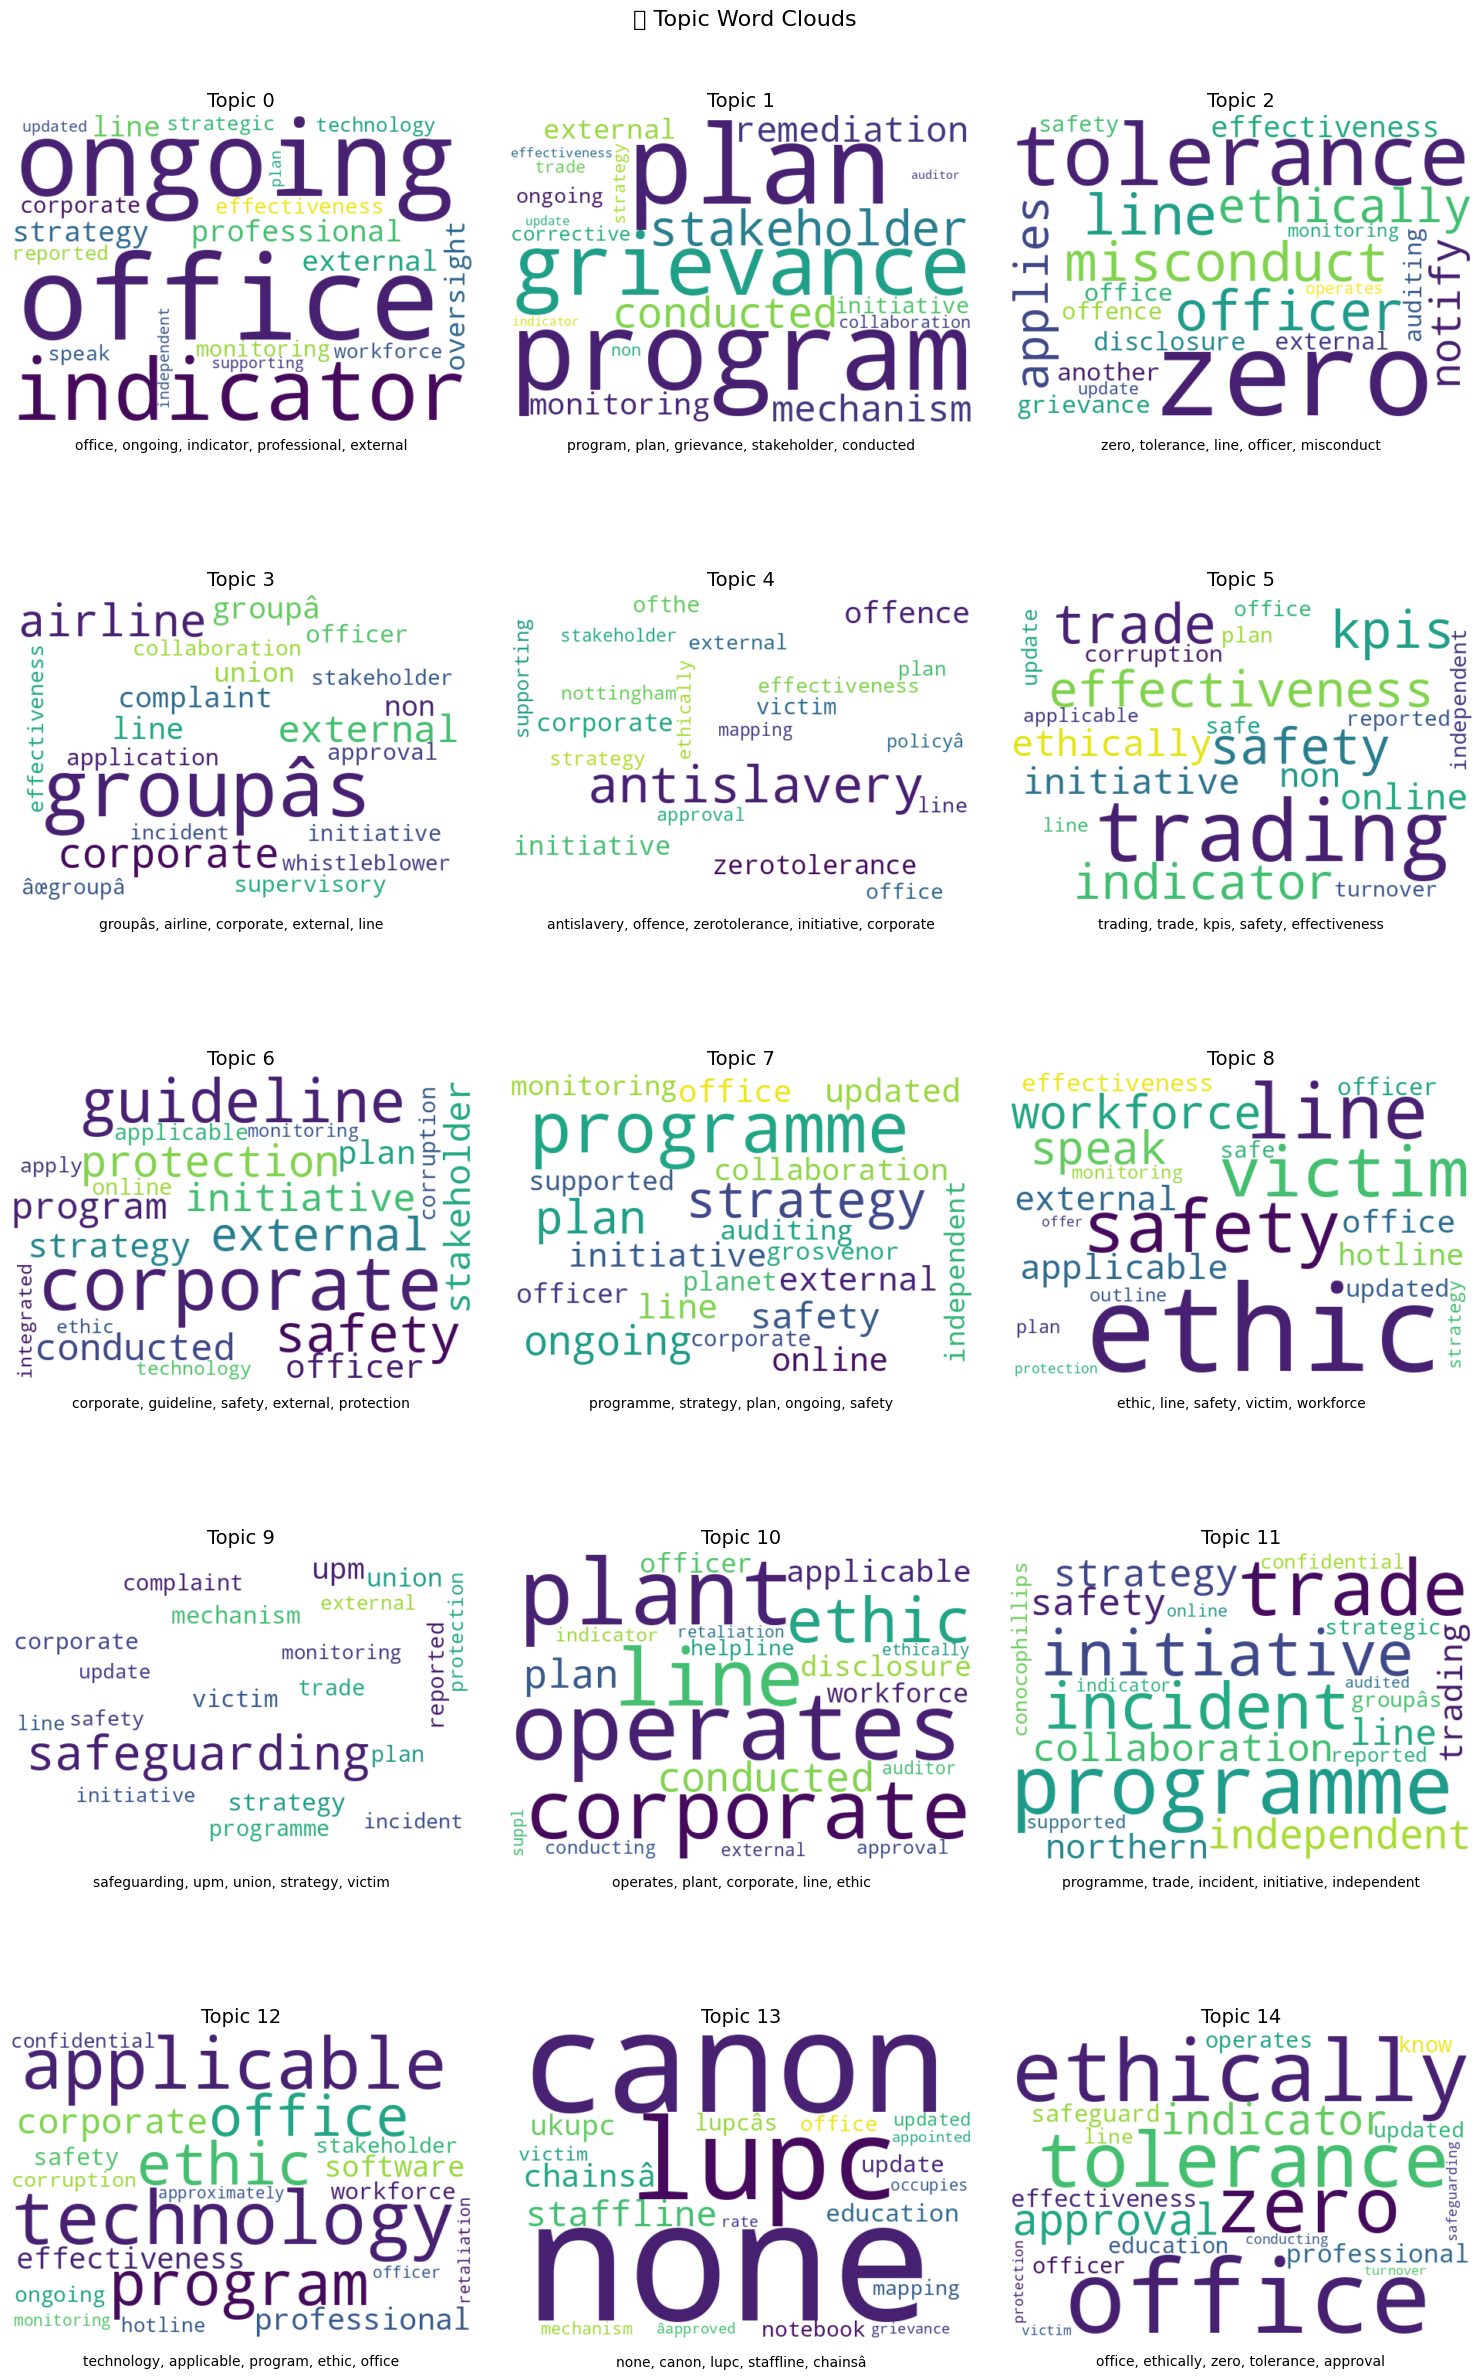

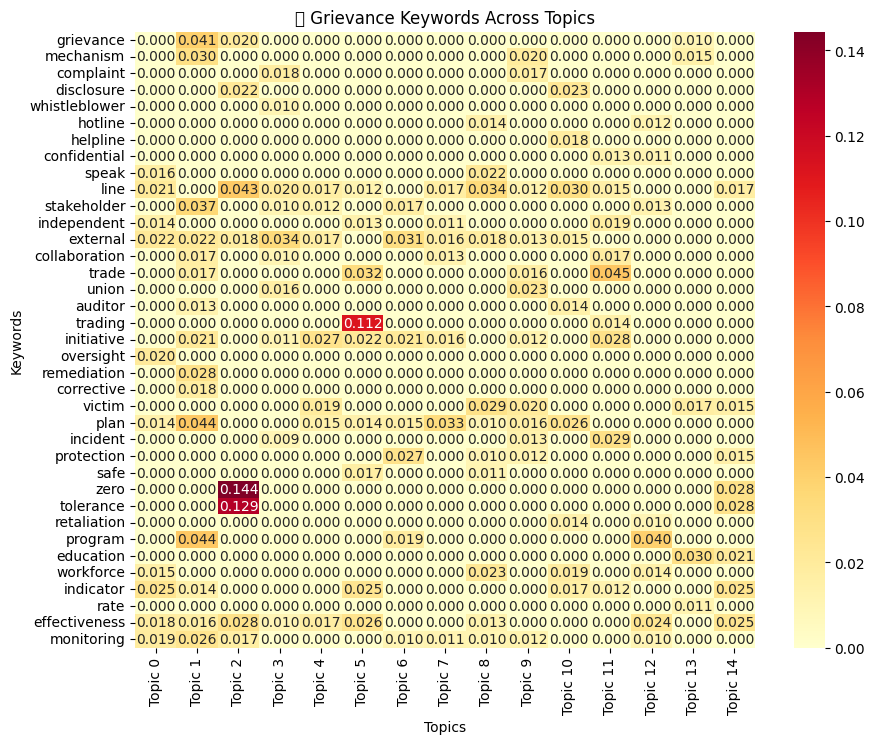

In [13]:
# Create comprehensive visualizations
if 'final_lda_model' in locals() and 'corpus' in locals() and 'dictionary' in locals():
    print("📊 Creating visualizations...")

    # Word Clouds
    num_topics = final_lda_model.num_topics
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if num_topics == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for topic_idx in range(num_topics):
        topic_words = dict(final_lda_model.show_topic(topic_idx, topn=20))
        wordcloud = WordCloud(
            width=600, height=400,
            background_color='white',
            colormap='viridis',
            max_words=20,
            relative_scaling=0.5,
            random_state=RANDOM_STATE
        ).generate_from_frequencies(topic_words)
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].set_title(f'Topic {topic_idx}', fontsize=14)
        axes[topic_idx].axis('off')
        top_5_words = [word for word, _ in final_lda_model.show_topic(topic_idx, topn=5)]
        axes[topic_idx].text(0.5, -0.05, ', '.join(top_5_words), transform=axes[topic_idx].transAxes,
                            ha='center', va='top', fontsize=10)

    for i in range(num_topics, len(axes)):
        axes[i].axis('off')
    plt.suptitle('🏷️ Topic Word Clouds', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Keyword Heatmap
    keyword_topic_matrix = {}
    for phrase in GRIEVANCE_KEYWORDS:
        words = phrase.lower().split()
        for word in words:
            if word not in keyword_topic_matrix:
                keyword_topic_matrix[word] = []
                for topic_idx in range(final_lda_model.num_topics):
                    topic_words = dict(final_lda_model.show_topic(topic_idx, topn=20))
                    keyword_weight = topic_words.get(word, 0.0)
                    keyword_topic_matrix[word].append(keyword_weight)

    keyword_df = pd.DataFrame(keyword_topic_matrix,
                             index=[f'Topic {i}' for i in range(final_lda_model.num_topics)])
    keyword_df = keyword_df.T
    keyword_df_filtered = keyword_df[keyword_df.sum(axis=1) > 0]

    if not keyword_df_filtered.empty:
        plt.figure(figsize=(10, 8))
        sns.heatmap(keyword_df_filtered, annot=True, fmt='.3f', cmap='YlOrRd')
        plt.title('🔑 Grievance Keywords Across Topics')
        plt.xlabel('Topics')
        plt.ylabel('Keywords')
        plt.show()
    else:
        print("⚠️ No grievance keywords found in topics.")
else:
    print("❌ No LDA model or corpus available.")


In [14]:
from google.colab import files
import os
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Step 8: Save and Download Results
print("📊 Checking available memory before saving...")
!free -h

if 'final_lda_model' in locals() and 'corpus' in locals() and 'dictionary' in locals():
    print("💾 Saving analysis results...")

    try:
        # Create output directory in Google Drive
        output_dir = '/content/drive/My Drive/LDA_Results/'
        os.makedirs(output_dir, exist_ok=True)

        # 1. Save topic summary
        if 'topics_df' in locals():
            topics_df.to_csv(os.path.join(output_dir, 'topic_summary.csv'), index=True)
            topics_df.to_csv('topic_summary.csv', index=True)
            print("✅ Topic summary saved as 'topic_summary.csv'")

        # 2. Save document-topic distributions
        print("🔄 Generating document-topic distributions...")
        doc_topic_dist = [final_lda_model[doc] for doc in corpus]
        doc_topic_df = pd.DataFrame(
            [[prob for _, prob in sorted(doc, key=lambda x: x[0])] for doc in doc_topic_dist],
            columns=[f'Topic {i}' for i in range(final_lda_model.num_topics)]
        )
        doc_topic_df.to_csv(os.path.join(output_dir, 'document_topic_distributions.csv'), index=False)
        doc_topic_df.to_csv('document_topic_distributions.csv', index=False)
        print("✅ Document-topic distributions saved as 'document_topic_distributions.csv'")

        # 3. Save dominant topic per document
        print("🔄 Generating dominant topic assignments...")
        dominant_topics = []
        for doc in doc_topic_dist:
            if doc:
                dominant_topic = max(doc, key=lambda x: x[1])[0]
                dominant_topics.append(dominant_topic)
            else:
                dominant_topics.append(-1)  # No topic assigned
        dominant_topic_df = pd.DataFrame({
            'Document': range(len(dominant_topics)),
            'Dominant Topic': dominant_topics,
            'Top Words': [', '.join([word for word, _ in final_lda_model.show_topic(t, topn=5)]) if t != -1 else 'None' for t in dominant_topics]
        })
        dominant_topic_df.to_csv(os.path.join(output_dir, 'dominant_topic_assignments.csv'), index=False)
        dominant_topic_df.to_csv('dominant_topic_assignments.csv', index=False)
        print("✅ Dominant topic assignments saved as 'dominant_topic_assignments.csv'")

        # 4. Save coherence scores
        if 'coherence_scores' in locals() and 'topic_range' in locals():
            coherence_df = pd.DataFrame({
                'Number of Topics': list(topic_range),
                'Coherence Score': coherence_scores
            })
            coherence_df.to_csv(os.path.join(output_dir, 'coherence_scores.csv'), index=False)
            coherence_df.to_csv('coherence_scores.csv', index=False)
            print("✅ Coherence scores saved as 'coherence_scores.csv'")

        # 5. Save grievance keywords analysis
        if 'keyword_df' in locals():
            keyword_df.to_csv(os.path.join(output_dir, 'grievance_keywords_analysis.csv'), index=True)
            keyword_df.to_csv('grievance_keywords_analysis.csv', index=True)
            print("✅ Grievance keywords analysis saved as 'grievance_keywords_analysis.csv'")

        # 6. Save pyLDAvis interactive visualization
        print("🔄 Generating pyLDAvis interactive visualization...")
        try:
            vis = gensimvis.prepare(final_lda_model, corpus, dictionary, sort_topics=False)
            pyLDAvis.save_html(vis, os.path.join(output_dir, 'lda_interactive_visualization.html'))
            pyLDAvis.save_html(vis, 'lda_interactive_visualization.html')
            print("✅ Interactive visualization saved as 'lda_interactive_visualization.html'")
        except Exception as e:
            print(f"⚠️ Failed to generate/save pyLDAvis visualization: {e}")

        # List and download files
        files_to_download = [
            'topic_summary.csv',
            'document_topic_distributions.csv',
            'dominant_topic_assignments.csv',
            'coherence_scores.csv',
            'grievance_keywords_analysis.csv',
            'lda_interactive_visualization.html'
        ]
        print("\n📁 Files ready for download:")
        available_files = [f for f in files_to_download if os.path.exists(f)]
        for file in available_files:
            print(f"   📄 {file}")

        print(f"\n🔽 Downloading {len(available_files)} files...")
        for file in available_files:
            try:
                files.download(file)
                print(f"   ✅ Downloaded: {file}")
            except Exception as e:
                print(f"   ⚠️ Could not download: {file} ({e})")

        print(f"\n📂 Files also saved to Google Drive: {output_dir}")
        print("\n🎉 Analysis results saved and downloaded successfully!")
        print("\n📊 What you now have:")
        print("   • Topic summary (top words per topic)")
        print("   • Document-topic distributions")
        print("   • Dominant topic assignments per document")
        print("   • Coherence scores for topic evaluation")
        print("   • Grievance keywords analysis")
        print("   • Interactive pyLDAvis HTML visualization for topic exploration")

        # Memory check after saving
        print("\n📊 Checking available memory after saving...")
        !free -h

    except Exception as e:
        print(f"⚠️ Error saving files: {e}")
        print("   The analysis was successful, but some files couldn't be saved or downloaded.")
else:
    print("❌ No model results available to save.")

📊 Checking available memory before saving...
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.2Gi       6.1Gi       2.0Mi       5.4Gi        11Gi
Swap:             0B          0B          0B
💾 Saving analysis results...
✅ Topic summary saved as 'topic_summary.csv'
🔄 Generating document-topic distributions...
✅ Document-topic distributions saved as 'document_topic_distributions.csv'
🔄 Generating dominant topic assignments...
✅ Dominant topic assignments saved as 'dominant_topic_assignments.csv'
✅ Coherence scores saved as 'coherence_scores.csv'
✅ Grievance keywords analysis saved as 'grievance_keywords_analysis.csv'
🔄 Generating pyLDAvis interactive visualization...
✅ Interactive visualization saved as 'lda_interactive_visualization.html'

📁 Files ready for download:
   📄 topic_summary.csv
   📄 document_topic_distributions.csv
   📄 dominant_topic_assignments.csv
   📄 coherence_scores.csv
   📄 grievance_keywords_analysis.csv
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: topic_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: document_topic_distributions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: dominant_topic_assignments.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: coherence_scores.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: grievance_keywords_analysis.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: lda_interactive_visualization.html

📂 Files also saved to Google Drive: /content/drive/My Drive/LDA_Results/

🎉 Analysis results saved and downloaded successfully!

📊 What you now have:
   • Topic summary (top words per topic)
   • Document-topic distributions
   • Dominant topic assignments per document
   • Coherence scores for topic evaluation
   • Grievance keywords analysis
   • Interactive pyLDAvis HTML visualization for topic exploration

📊 Checking available memory after saving...
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.4Gi       5.8Gi       2.0Mi       5.4Gi        10Gi
Swap:             0B          0B          0B
